## Towards A Better Understanding of Typical Learning-to-rank Methods Based on PT-Ranking, Such as RankNet & LambdaRank

## 1 Sigmoid Function & Logistic Function

A sigmoid function **having a characteristic of S-shaped curve** is defined as follows,

$$ f(x)=\frac{1}{1+\exp(-x)} $$

A logistic function is defined as,

$$ f(x)=\frac{L}{1+\exp(-k(x-x_0))} $$

Commonly, with parameters ($k=1$, $x_0=0$, $L=1$), the standard logistic function is just a sigmoid function.

Text(0, 0.5, 'f(x)')

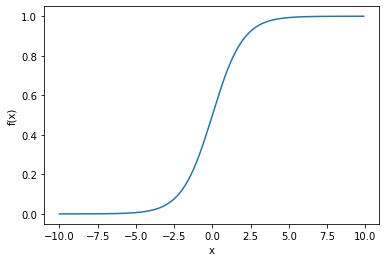

In [1]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(-10, 10, 0.1)
f = 1. / (1. + np.exp(-x))

plt.plot(x, f)
plt.xlabel('x')
plt.ylabel('f(x)')

## 2 RankNet

Given two documents $d_i$ and $d_j$ that are represented as feature vectors $\mathbf{x}_i$ and $\mathbf{x}_j$, let $f$ be the ranking function, the ranking scores will be $s_i=f(\mathbf{x}_i)$ and $s_j=f(\mathbf{x}_j)$, the probability $p_{ij}$ indicating $d_i$ should be ranked higher than $d_j$ is given as

$$ p_{ij}=\frac{1}{1+\exp(-(s_i-s_j))} $$

### 2.1 Loss of pairwise classification

Let $\bar{p_{ij}}$ be the known probability that $d_i$ should be ranked higher than $d_j$, we then apply the cross entropy cost function that penalizes the deviation of the model output probabilities from the desired probabilities,

$$ C=-\bar{p_{ij}} \log(p_{ij}) - (1-\bar{p_{ij}})\log(1-p_{ij}) $$

For a given query, let $S_{ij}\in \{-1, 0, 1\}$ be defined to be 1 if doc-i has been labeled to be more relevant than doc-j, −1 if doc-i has been labeled to be less relevant than doc-j, and 0 if they have the same label. In particular, we assume that the desired ranking is deterministically known, so that $\bar{p_{ij}}=\frac{1}{2}(1+S_{ij})$. Combining the above two equations gives

$$ C=\frac{1}{2}(1-S_{ij})(s_i-s_j) + \log(1+\exp(-(s_i-s_j))) $$

The cost is comfortingly symmetric (swapping $i$ and $j$ and changing the sign of $S_{ij}$ should leave the cost invariant): for $S_{ij}=1$,

$$ C=\log(1+\exp(-(s_i-s_j))) $$

while for $S_{ij}=-1$,

$$ C=\log(1+\exp(-(s_j-s_i))) $$

Note that when $s_i = s_j$, the cost is $\log2$, so the model incorporates a margin (that is, documents with different labels, but to which the model assigns the same scores, are still pushed away from each other in the ranking). Also, asymptotically, the cost becomes linear (if the scores give the wrong ranking), or zero (if they give the correct ranking).

For the gradient, essentially we have

$$\frac{\partial C}{\partial s_{i}}=\frac{1}{2}(1-S_{ij})-\frac{1}{1+e^{(s_{i}-s_{j})}}=-\frac{\partial C}{\partial s_{j}}$$

Furthermore,

$\frac{\partial^{2} C}{\partial s_{i}^{2}}=\sigma (s_{j}-s_{i})(1-\sigma (s_{j}-s_{i}))
=\frac{1}{1+e^{(s_{i}-s_{j})}} (1-\frac{1}{1+e^{(s_{i}-s_{j})}})=-\frac{\partial^{2} C}{\partial s_{j}^{2}}$

## 3 LambdaRank

The key observation of LambdaRank is that: in order to train a model, we don't need the costs themselves, and we only need the gradients of the costs w.r.t. the model scores.

We denote the gradient $\frac{\partial C}{\partial s_{i}}$ as $\lambda_{ij}$, namely

$
\lambda_{ij}=\frac{\partial C(s_{i}-s_{j})}{\partial s_{i}}=\frac{1}{2}(1-S_{ij})-\frac{1}{1+e^{(s_{i}-s_{j})}}
$

LambdaRank mainly differs from RankNet in that: modifying the above gradient by simply multiplying by the size of change in a particular metric $|\Delta nDCG|$ (say, in term of $nDCG$) given by swapping the rank positions of $d_i$ and $d_j$ while leaving the rank positions of other documents unchanged.

## 4 An Empirical Study of RankNet and LambdaRank Based on PT-Ranking

### 4.1 Declare a plot function for visualization

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def show_var(list_vals, lbl=None):
    X = np.arange(start=1, stop=len(list_vals)+1).tolist()
    if lbl is not None:
        plt.plot(X, list_vals, label=lbl)
    else:
        plt.plot(X, list_vals)

### 4.2 Specify dataset, output directory, initialize the evaluation object, etc.


In [3]:
import sys
sys.path.append('../')
from ptranking.ltr_adhoc.eval.ltr import LTREvaluator
from ptranking.eval.parameter import DataSetting, EvalSetting, ModelParameter, ScoringFunctionParameter

''' dataset identifier '''
data_id = 'MQ2008_Super'

''' directory of the corresponding dataset '''
# dir_data = '/Users/dryuhaitao/WorkBench/Corpus/LETOR4.0/MQ2007/'
# dir_data = '/Users/solar/WorkBench/Datasets/L2R/LETOR4.0/MQ2008/'
dir_data = '../MQ2008/'

''' output directory for results '''
dir_output='../output/'
#dir_output = '/Users/solar/WorkBench/CodeBench/PyCharmProject/Project_output/Out_L2R/'

''' the main class for conducting training & testing '''
ltr_evaluator = LTREvaluator()

debug = True # in a debug mode, we just check whether the model can operate

''' using the default setting for loading dataset & using the default setting for evaluation '''
ltr_evaluator.set_eval_setting(debug=debug, dir_output=dir_output)
ltr_evaluator.set_data_setting(debug=debug, data_id=data_id, dir_data=dir_data)
data_dict = ltr_evaluator.get_default_data_setting()
eval_dict = ltr_evaluator.get_default_eval_setting()

### 4.3 Prepare data

In [4]:
''' load the dataset '''
train_data, test_data, vali_data = ltr_evaluator.load_data(eval_dict=eval_dict, data_dict=data_dict, fold_k=1)

Fold- 1
data_dict {'data_id': 'MQ2008_Super', 'dir_data': '../MQ2008/', 'min_docs': 10, 'min_rele': 1, 'scale_data': False, 'scaler_id': None, 'scaler_level': None, 'train_presort': True, 'validation_presort': True, 'test_presort': True, 'train_batch_size': 1, 'validation_batch_size': 1, 'test_batch_size': 1, 'unknown_as_zero': False, 'binary_rele': False, 'num_features': 46, 'has_comment': True, 'label_type': <LABEL_TYPE.MultiLabel: 1>, 'max_rele_level': 2, 'fold_num': 5}
../MQ2008/Fold1/train.txt


FileNotFoundError: [Errno 2] No such file or directory: '../MQ2008/Fold1/train.txt'

In [ ]:
train_data.list_torch_Qs[1][1].shape

### 4.3 Configuration of the neural scoring function

In [ ]:
''' using the default setting for constructing a neural scoring function '''
ltr_evaluator.set_scoring_function_setting(debug=debug, data_dict=data_dict)
sf_para_dict = ltr_evaluator.get_default_scoring_function_setting()

### 4.4 An example play - RankNet

In [ ]:
''' the parameter setting for a model '''
model_id = 'RankNet' # The specified model with default parameters
ltr_evaluator.set_model_setting(debug=debug, model_id=model_id)
model_para_dict = ltr_evaluator.get_default_model_setting()

''' basic check before loading the ranker '''
ltr_evaluator.setup_eval(data_dict=data_dict, eval_dict=eval_dict, sf_para_dict=sf_para_dict, model_para_dict=model_para_dict)

''' initialize the ranker '''
ranknet   = ltr_evaluator.load_ranker(sf_para_dict=sf_para_dict, model_para_dict=model_para_dict)

### 4.4.1 Train RankNet and Plot

In [ ]:
ranknet_losses, ranknet_train_ndcgs, ranknet_test_ndcgs = ltr_evaluator.naive_train(ranker=ranknet, eval_dict=eval_dict, train_data=train_data, test_data=test_data)

show_var(ranknet_losses, lbl='Training loss') # show the variation of loss
plt.legend()
plt.title('RankNet')

In [ ]:
cutoffs = [1, 3, 5, 10, 20, 50]

for i in range(len(cutoffs)):
    k = cutoffs[i]
    show_var(ranknet_train_ndcgs[:, i], lbl='Train-nDCG@'+str(k))
plt.legend()
plt.title('RankNet')

In [ ]:
for i in range(len(cutoffs)):
    k = cutoffs[i]
    show_var(ranknet_test_ndcgs[:, i], lbl='Test-nDCG@'+str(k))
plt.legend()
plt.title('RankNet')

### 4.5 An example play - LambdaRank

In [ ]:
''' the parameter setting for a model '''
model_id = 'LambdaRank' # The specified model with default parameters
data_dict = ltr_evaluator.get_default_data_setting()
# ltr_evaluator.set_model_setting(debug=debug, model_id=model_id, data_dict=data_dict) # data_dict argument is required
ltr_evaluator.set_model_setting(debug=debug, model_id=model_id) # data_dict argument is required
model_para_dict = ltr_evaluator.get_default_model_setting()

''' basic check before loading the ranker '''
ltr_evaluator.setup_eval(data_dict=data_dict, eval_dict=eval_dict, sf_para_dict=sf_para_dict, model_para_dict=model_para_dict)

''' initialize the ranker '''
lambdarank   = ltr_evaluator.load_ranker(sf_para_dict=sf_para_dict, model_para_dict=model_para_dict)

### 4.5.1 Train LambdaRank and Plot

In [ ]:
lambdarank_losses, lambdarank_train_ndcgs, lambdarank_test_ndcgs = ltr_evaluator.naive_train(ranker=lambdarank, eval_dict=eval_dict, train_data=train_data, test_data=test_data)

show_var(lambdarank_losses, lbl='Training loss') # show the variation of loss
plt.legend()
plt.title('LambdaRank')

In [ ]:
for i in range(len(cutoffs)):
    k = cutoffs[i]
    show_var(lambdarank_train_ndcgs[:, i], lbl='Train-nDCG@'+str(k))
plt.legend()
plt.title('LambdaRank')

In [ ]:
for i in range(len(cutoffs)):
    k = cutoffs[i]
    show_var(lambdarank_test_ndcgs[:, i], lbl='Test-nDCG@'+str(k))
plt.legend()
plt.title('LambdaRank')
